XGBoost forecasting

# Import all libraries we will need

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Connect to Goole Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read the files with pandas

In [ ]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/holidays_events.csv')

In [ ]:
# Load the filtered dataset with features
df_filtered = pd.read_csv('/content/drive/My Drive/df_filled_with_features_filtered.csv', parse_dates=['date'])



# Display the first few rows
print(df_filtered.head())

        date  store_nbr  item_nbr  unit_sales  onpromotion  year  month  day  \
0 2014-01-01         24     96995         0.0        False  2014      1    1   
1 2014-01-02         24     96995         3.0        False  2014      1    2   
2 2014-01-03         24     96995         2.0        False  2014      1    3   
3 2014-01-04         24     96995         0.0        False  2014      1    4   
4 2014-01-05         24     96995         0.0        False  2014      1    5   

   day_of_week  unit_sales_7d_avg  
0            2           0.000000  
1            3           1.500000  
2            4           1.666667  
3            5           1.250000  
4            6           1.000000  


In [ ]:


# let's have a list that top-3 families in it
item_families = ['GROCERY I', 'BEVERAGES', 'CLEANING']

# now, we can get ids for the items that are in these familieis
item_ids = df_items[df_items['family'].isin(item_families)]['item_nbr'].unique()

# next, we read in the train.csv data and
# filter it out to get desriesd item ids
# here is how we filter
df_filtered = df_filtered[df_filtered['item_nbr'].isin(item_ids)]

In [ ]:
print(df_filtered.shape)
print(df_filtered.head())

(1870920, 10)
        date  store_nbr  item_nbr  unit_sales  onpromotion  year  month  day  \
0 2014-01-01         24     96995         0.0        False  2014      1    1   
1 2014-01-02         24     96995         3.0        False  2014      1    2   
2 2014-01-03         24     96995         2.0        False  2014      1    3   
3 2014-01-04         24     96995         0.0        False  2014      1    4   
4 2014-01-05         24     96995         0.0        False  2014      1    5   

   day_of_week  unit_sales_7d_avg  
0            2           0.000000  
1            3           1.500000  
2            4           1.666667  
3            5           1.250000  
4            6           1.000000  


# Prepare data

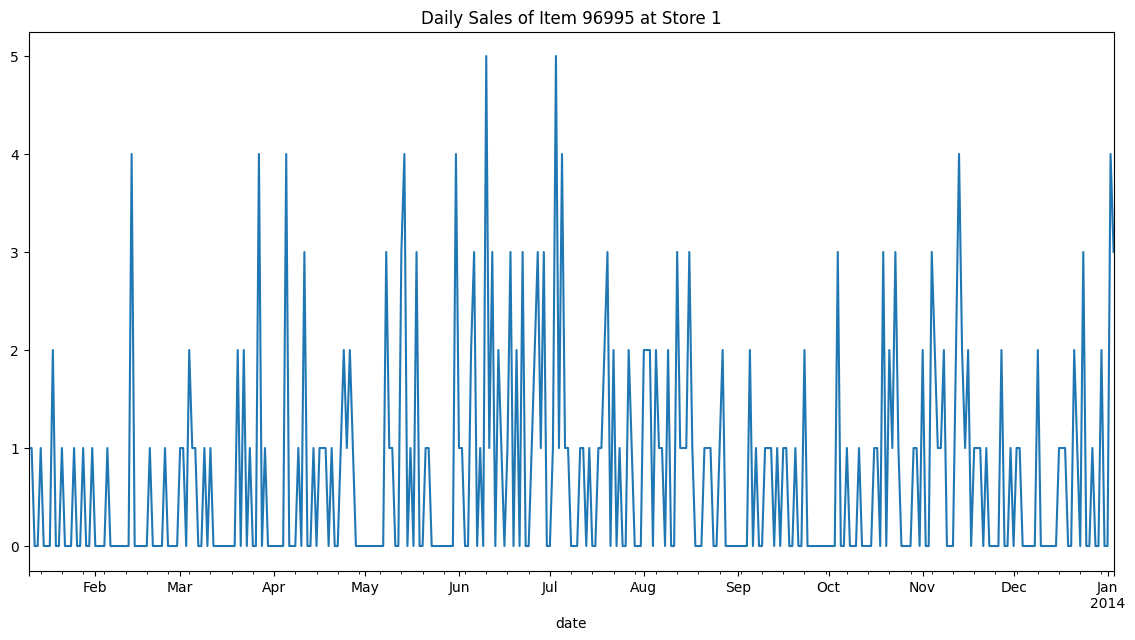

In [ ]:
'''df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Group by date and aggregate sales
df_filtered = df_filtered.groupby('date').sum()['unit_sales'].reset_index()

# Fill missing dates with zero sales
df_filtered.set_index('date', inplace=True)
df_filtered = df_filtered.asfreq('D').fillna(0)

# Visualize sales data
plt.figure(figsize=(14, 7))
df_filtered['unit_sales'].plot()
plt.title('Daily Sales of Item 96995 at Store 1')
plt.show()'''

# Prepare features

## Creating Lag Features

In [ ]:
# Create lag features (e.g., sales from the previous day, previous week)
df_filtered['lag_1'] = df_filtered['unit_sales'].shift(1)
df_filtered['lag_7'] = df_filtered['unit_sales'].shift(7)
df_filtered['lag_30'] = df_filtered['unit_sales'].shift(30)

# Drop any rows with NaN values after creating lag features
df_filtered.dropna(inplace=True)


## Creating Rolling Statistics

In [ ]:
# Create rolling mean and rolling standard deviation features
#df_filtered['rolling_mean_7'] = df_filtered['unit_sales'].rolling(window=7).mean()
df_filtered['rolling_std_7'] = df_filtered['unit_sales'].rolling(window=7).std()

# Drop any NaN values after creating rolling features
df_filtered.dropna(inplace=True)

# Visualize the new features alongside the original sales
'''df_filtered[['unit_sales', 'rolling_mean_7', 'rolling_std_7']].plot(figsize=(14, 7))
plt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')
plt.show()'''

"df_filtered[['unit_sales', 'rolling_mean_7', 'rolling_std_7']].plot(figsize=(14, 7))\nplt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')\nplt.show()"

## Adding Date-based Features

In [ ]:
# Add date-based features
#df_filtered['day_of_week'] = df_filtered.index.dayofweek
#df_filtered['month'] = df_filtered.index.month
df_filtered['is_weekend'] = df_filtered['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [ ]:
# let's assumne that train_df is the variable that has the data in it
# and df_stores is the dataframe that contains data about stores
# so you can merge these two dataframes like this:
df_filtered = df_filtered.merge(df_stores, on='store_nbr', how='left')

# let's also assume that df_items is the dataframe that
# contains data obout items. So, let's merge now
df_filtered = df_filtered.merge(df_items, on='item_nbr', how='left')

In [ ]:
df_filtered.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,...,lag_30,rolling_std_7,is_weekend,city,state,type,cluster,family,class,perishable
0,2014-02-06,24,96995,0.0,False,2014,2,6,3,1.142857,...,1.0,0.690066,0,Guayaquil,Guayas,D,1,GROCERY I,1093,0
1,2014-02-07,24,96995,0.0,False,2014,2,7,4,1.000000,...,0.0,0.816497,0,Guayaquil,Guayas,D,1,GROCERY I,1093,0
2,2014-02-08,24,96995,0.0,False,2014,2,8,5,0.857143,...,1.0,0.899735,1,Guayaquil,Guayas,D,1,GROCERY I,1093,0
3,2014-02-09,24,96995,0.0,False,2014,2,9,6,0.714286,...,0.0,0.951190,1,Guayaquil,Guayas,D,1,GROCERY I,1093,0
4,2014-02-10,24,96995,0.0,False,2014,2,10,0,0.571429,...,0.0,0.975900,0,Guayaquil,Guayas,D,1,GROCERY I,1093,0


In [ ]:
# Perform one-hot encoding for the 'family' column
df_filtered = pd.get_dummies(df_filtered, columns=['family'], drop_first=True)

# Display the first few rows to verify
print(df_filtered.head())

        date  store_nbr  item_nbr  unit_sales  onpromotion  year  month  day  \
0 2014-02-06         24     96995         0.0        False  2014      2    6   
1 2014-02-07         24     96995         0.0        False  2014      2    7   
2 2014-02-08         24     96995         0.0        False  2014      2    8   
3 2014-02-09         24     96995         0.0        False  2014      2    9   
4 2014-02-10         24     96995         0.0        False  2014      2   10   

   day_of_week  unit_sales_7d_avg  ...  rolling_std_7  is_weekend       city  \
0            3           1.142857  ...       0.690066           0  Guayaquil   
1            4           1.000000  ...       0.816497           0  Guayaquil   
2            5           0.857143  ...       0.899735           1  Guayaquil   
3            6           0.714286  ...       0.951190           1  Guayaquil   
4            0           0.571429  ...       0.975900           0  Guayaquil   

    state  type cluster class perishab

# Split data in training and test

In [ ]:
# Define target variable (unit_sales) and features
X = df_filtered.drop(['unit_sales', 'date', 'city', 'state','type'], axis=1)
y = df_filtered['unit_sales']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ML model with XGBoost

In [ ]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

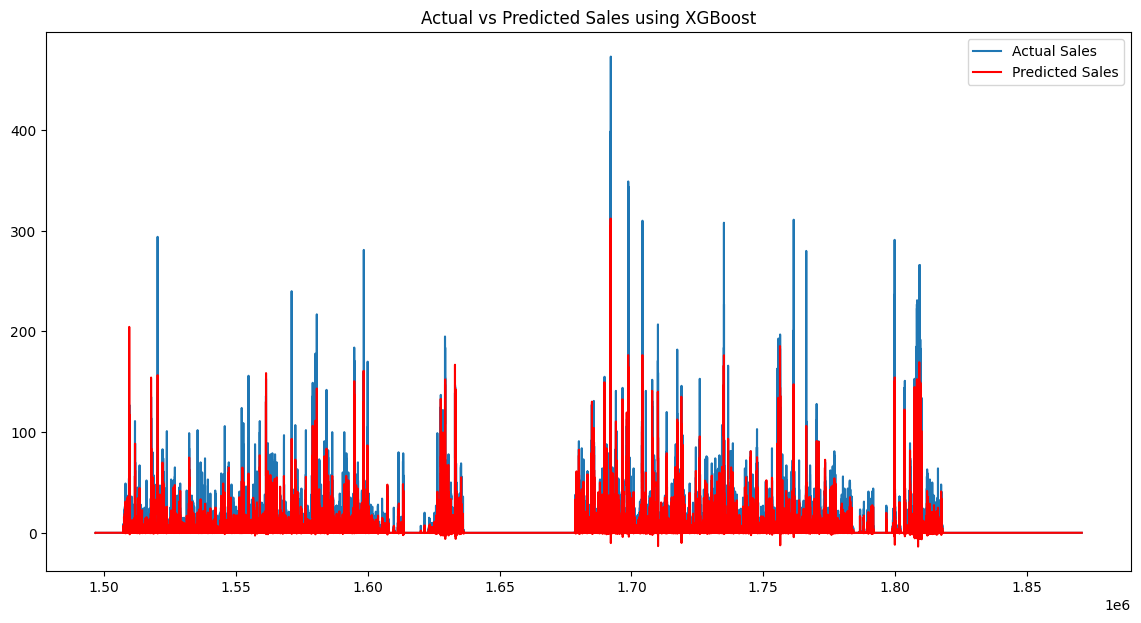

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Define the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Number of trees
    'max_depth': [3, 5, 7, 10],           # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2, 0.3]  # Step size for each boosting step
}

# TimeSeriesSplit for time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # 5 time-based splits

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb_model,  # The model to tune
    param_grid=param_grid,  # Parameter grid to search
    scoring='neg_root_mean_squared_error',  # Metric to optimize (negative RMSE)
    cv=tscv,  # Use TimeSeriesSplit for cross-validation
    verbose=1,  # Print progress
    n_jobs=-1  # Use all available CPU cores
)

# Train the model (assuming X_train and y_train are already defined)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
